In [29]:
import opendatasets as od
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [30]:
DATA_DIR = './Dataset_Binary_Classification/images'

In [31]:
IMAGE_SIZE = 128  # Resize to 128x128

def load_images(data_dir, image_size=IMAGE_SIZE):
    images = []
    masks = []
    labels = []

    tumor_types = ['tumor', 'notumor']
    for idx, tumor_type in enumerate(tumor_types):
        img_dir = os.path.join(data_dir, tumor_type)
        for filename in os.listdir(img_dir):
            img_path = os.path.join(img_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0  # Normalize to [0, 1]

            # Generate a dummy mask for now (binary mask, 0 or 1)
            mask = np.zeros_like(image)
            if tumor_type != 'notumor':
                mask[image > 0] = 1

            images.append(image)
            masks.append(mask)
            labels.append(idx)  # Assign a label for each tumor type

    images = np.array(images, dtype=np.float32).reshape(-1, image_size, image_size, 1)
    masks = np.array(masks, dtype=np.float32).reshape(-1, image_size, image_size, 1)
    labels = np.array(labels, dtype=np.int64)

    return images, masks, labels

images, masks, labels = load_images(f"{DATA_DIR}")

In [32]:
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        self.images = images
        self.masks = masks
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask, label

In [33]:
dataset = BrainTumorDataset(images, masks, labels, transform=transforms.ToTensor())
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [34]:
class MultiTaskUNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MultiTaskUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder_segmentation = nn.Conv2d(64, 1, kernel_size=1)  # For segmentation
        self.decoder_classification = nn.Linear(64 * IMAGE_SIZE * IMAGE_SIZE, num_classes)  # For classification

    def forward(self, x):
        x1 = self.encoder(x)
        seg_output = self.decoder_segmentation(x1)

        # Classification output
        x_flat = torch.flatten(x1, 1)
        class_output = self.decoder_classification(x_flat)

        return seg_output, class_output


In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4  # glioma, meningioma, pituitary, no_tumor
model = MultiTaskUNet(in_channels=1, num_classes=num_classes).to(device)
criterion_seg = nn.BCEWithLogitsLoss()
criterion_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [44]:
def train_model(model, train_loader, criterion_seg, criterion_class, optimizer, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        total_seg_correct = 0
        total_class_correct = 0
        total_pixels = 0
        total_samples = 0

        for images, masks, labels in train_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            seg_outputs, class_outputs = model(images)

            # Compute losses
            loss_seg = criterion_seg(seg_outputs, masks)
            loss_class = criterion_class(class_outputs, labels)
            loss = loss_seg + loss_class

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Accuracy for segmentation (assuming binary segmentation)
            predicted_masks = (seg_outputs > 0.3).float()  # Thresholding to get binary predictions
            total_seg_correct += (predicted_masks == masks).sum().item()
            total_pixels += masks.numel()  # Total number of pixels

            # Accuracy for classification
            _, predicted_labels = torch.max(class_outputs, 1)  # Get predicted class indices
            total_class_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

        # Compute average loss and accuracy
        avg_loss = epoch_loss / len(train_loader)
        seg_accuracy = total_seg_correct / total_pixels * 100
        class_accuracy = total_class_correct / total_samples * 100

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
              f'Segmentation Accuracy: {seg_accuracy:.2f}%, '
              f'Classification Accuracy: {class_accuracy:.2f}%')

# Call the function to train and track accuracy
train_model(model, train_loader, criterion_seg, criterion_class, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.7962, Segmentation Accuracy: 48.68%, Classification Accuracy: 97.59%
Epoch [2/10], Loss: 0.7434, Segmentation Accuracy: 48.68%, Classification Accuracy: 99.08%
Epoch [3/10], Loss: 0.7310, Segmentation Accuracy: 48.68%, Classification Accuracy: 99.20%
Epoch [4/10], Loss: 0.7045, Segmentation Accuracy: 48.67%, Classification Accuracy: 99.77%
Epoch [5/10], Loss: 0.6953, Segmentation Accuracy: 48.65%, Classification Accuracy: 100.00%
Epoch [6/10], Loss: 0.6951, Segmentation Accuracy: 48.67%, Classification Accuracy: 99.77%
Epoch [7/10], Loss: 0.6897, Segmentation Accuracy: 48.78%, Classification Accuracy: 100.00%
Epoch [8/10], Loss: 0.6859, Segmentation Accuracy: 49.36%, Classification Accuracy: 100.00%
Epoch [9/10], Loss: 0.6816, Segmentation Accuracy: 50.43%, Classification Accuracy: 100.00%
Epoch [10/10], Loss: 0.6782, Segmentation Accuracy: 52.49%, Classification Accuracy: 100.00%


In [37]:
def plot_predictions(model, dataloader, num_images=5):
    model.eval()
    images, masks, labels = next(iter(dataloader))
    images, masks, labels = images[:num_images], masks[:num_images], labels[:num_images]
    
    tumor_types = ['tumor', 'notumor']  # List of tumor types
    
    with torch.no_grad():
        seg_predictions, class_predictions = model(images.to(device))

    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i in range(num_images):
        # Show the original image
        axs[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axs[i, 0].set_title(f"Original Image, Condition: {tumor_types[labels[i].item()]}")
        
        # Show the predicted mask
        axs[i, 1].imshow(seg_predictions[i].cpu().squeeze().numpy() > 0.3, cmap='gray')
        axs[i, 1].set_title(f"Predicted Mask, Condition: {tumor_types[class_predictions[i].argmax().item()]}")
    
    plt.show()

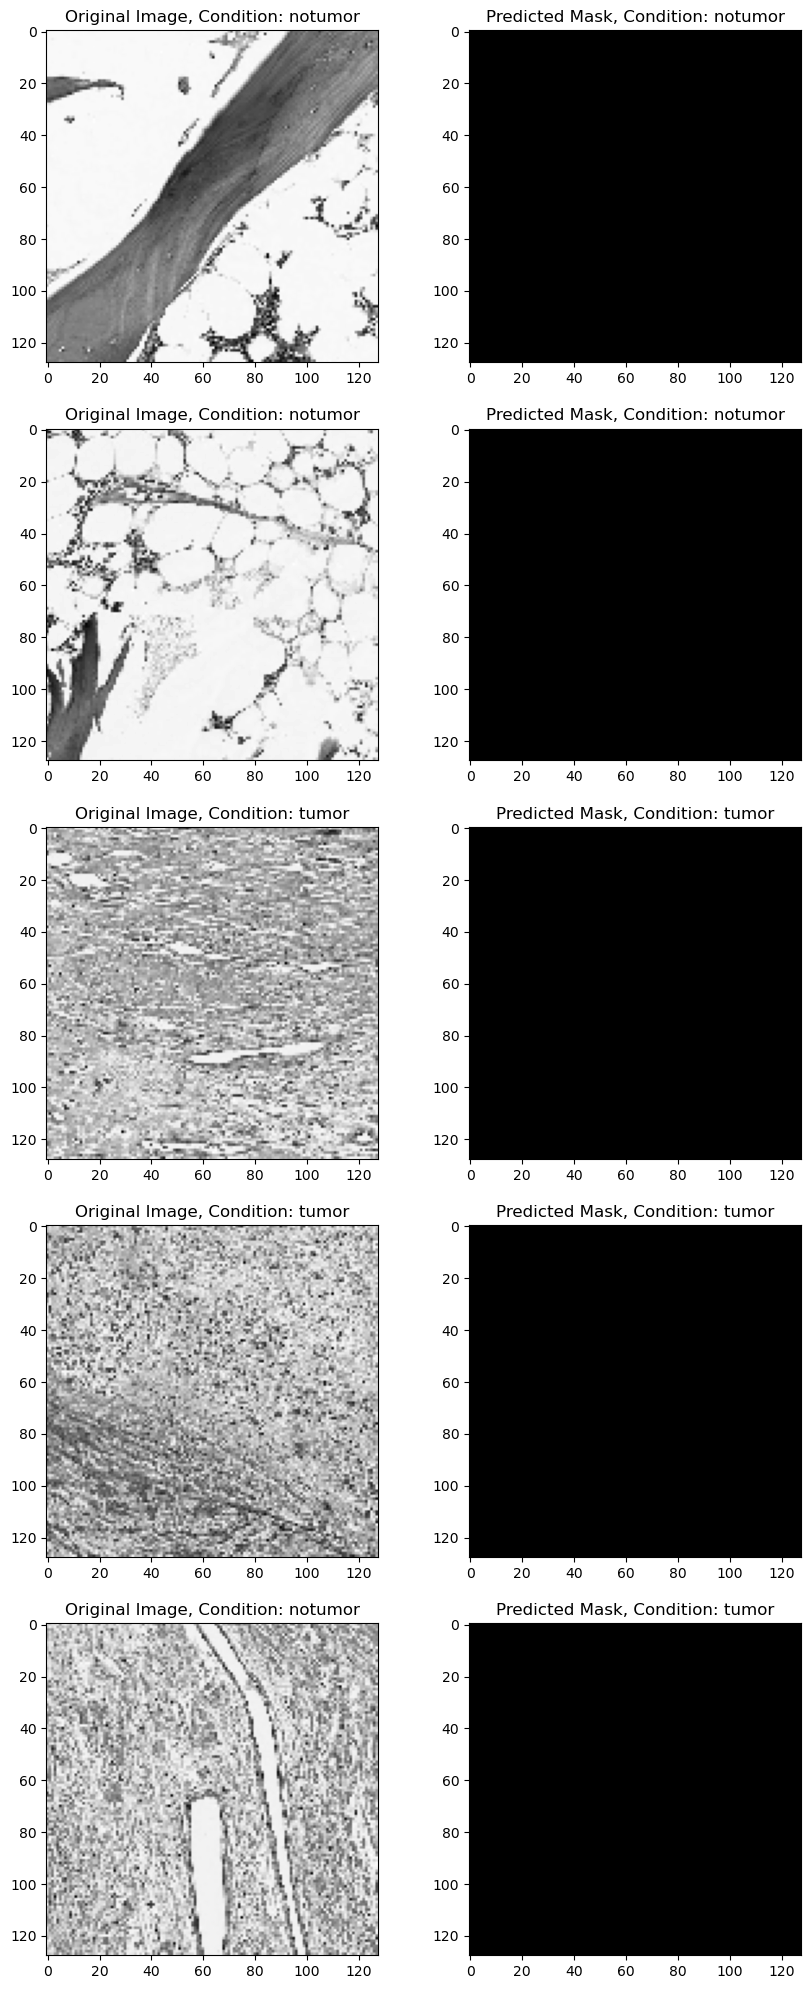

In [38]:
plot_predictions(model, val_loader)

In [ ]:
torch.save(model.state_dict(), 'multi_task_unet_bone.pth')
print("Model saved successfully.")

Model saved successfully.


In [40]:
def load_model(model_path, device='cpu'):
    model = MultiTaskUNet(in_channels=1, num_classes=4).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [41]:
def preprocess_image(image_path, image_size=128):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0  # Normalize to [0, 1]
    image = image.astype(np.float32)
    # Add a channel dimension (1, H, W)
    image = np.expand_dims(image, axis=0)
    # Convert to tensor
    image = torch.tensor(image).unsqueeze(0)  # Shape: (1, 1, H, W)
    return image

In [42]:
def predict(image_path, model, device='cpu'):
    # Preprocess the input image
    image = preprocess_image(image_path).to(device)

    # Perform inference
    with torch.no_grad():
        seg_output, class_output = model(image)

    # Process the outputs
    # Segmentation mask
    seg_mask = (seg_output.squeeze().cpu().numpy() > 0.3).astype(np.uint8)

    # Classification result
    tumor_types = ['tumor', 'notumor']
    predicted_label = tumor_types[class_output.argmax(dim=1).item()]

    return seg_mask, predicted_label

C:\Users\mccra\AppData\Local\Temp\ipykernel_30036\3244378230.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

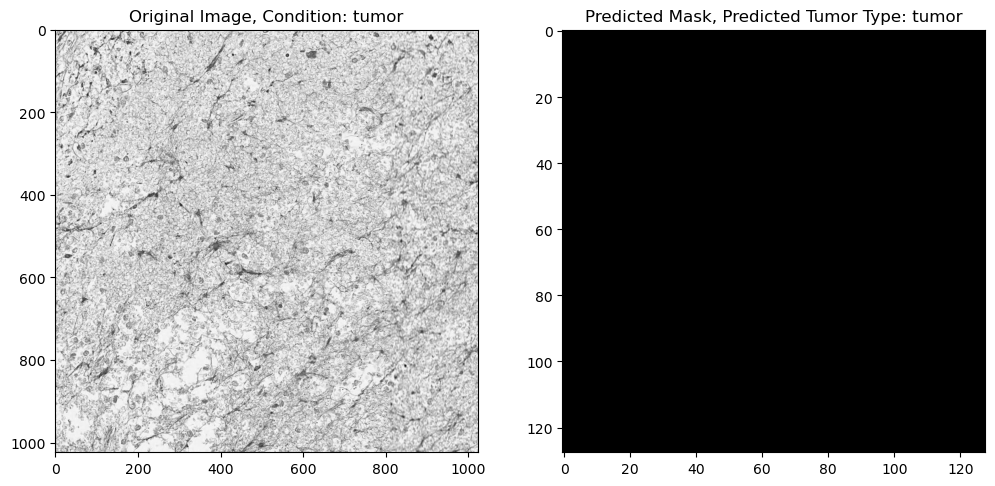

In [ ]:
# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model('multi_task_unet_bone.pth', device)

# Test image path and extracting ground truth tumor type from the path
test_image_path = f"{DATA_DIR}/tumor/Case-3-A7-27102-7995.jpg"  
ground_truth_tumor_type = test_image_path.split('/')[-2]  # Extract tumor type from file path

# Get the predicted segmentation mask and tumor type from the model
segmentation_mask, predicted_tumor_type = predict(test_image_path, model, device)

# Display the results
plt.figure(figsize=(12, 6))

# Original image with ground truth condition
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title(f"Original Image, Condition: {ground_truth_tumor_type}")

# Predicted mask with predicted tumor type
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap='gray')
plt.title(f"Predicted Mask, Predicted Tumor Type: {predicted_tumor_type}")

plt.show()
